In [197]:
## Source the files in the "functions" folder
files <- dir("functions",full.names=TRUE)
for(i in 1:length(files)) source(files[i])

### read & plot


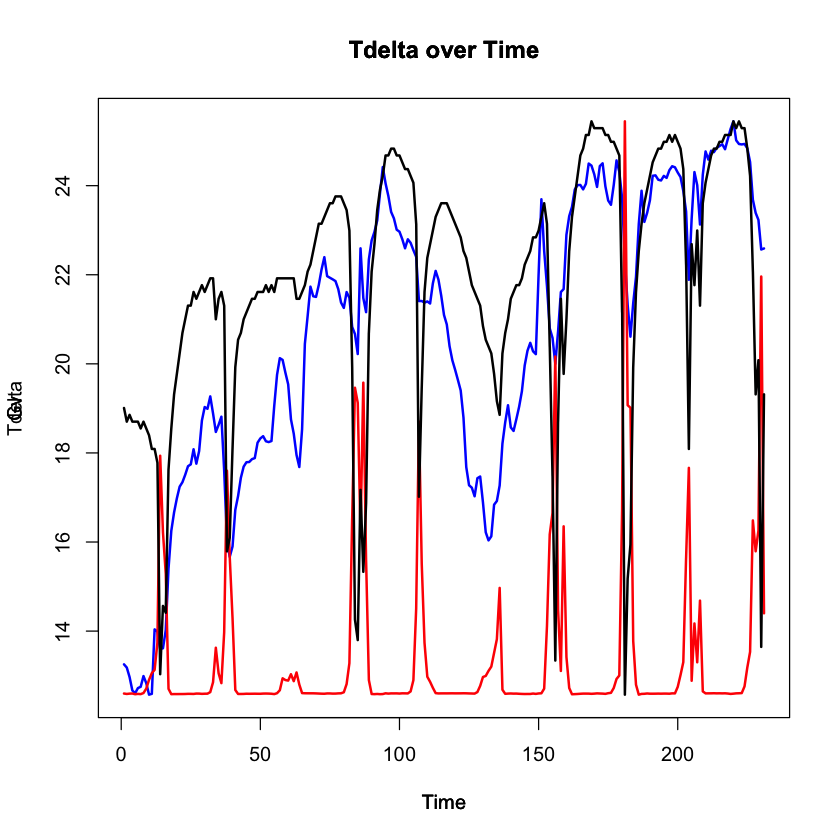

In [198]:
D <- read.csv("box_data_60min.csv", header = TRUE)
D$thour <- D$thour-D$thour[1]+1

par(bg = 'white')
plot(D$thour,D$Tdelta, type = "l", col = "blue", lwd = 2, xlab = "Time", ylab = "Tdelta", main = "Tdelta over Time")
# plot on the same graph secondary y-axis
par(new = TRUE)
plot(D$thour,D$Gv, type = "l", col = "red", lwd = 2, xlab = "Time", ylab = "Gv", main = "Tdelta over Time", axes = FALSE)
# third y axis
par(new = TRUE)
plot(D$thour,D$Ph, type = "l", col = "black", lwd = 2, xlab = "Time", ylab = "Gv", main = "Tdelta over Time", axes = FALSE)

2. Split the data into a train and test set, such that ”2013-02-06 00:00” is the last data point in the
training set (i.e. thour = 1, ..., 167 is the training set). From now on, work only on the training
set, except where explicitly told to use the test set.

In [199]:
## Divide intro train and test set
teststart <- 167
Dtrain <- D[D$thour < teststart, ]
Dtest <- D[D$thour >= teststart, ]

# show first 10 rows of the training set
head(Dtrain, 5)


,thour,tdate,Ph,Tdelta,Gv,Ph.l0,Ph.l1,Ph.l2,Ph.l3,Ph.l4,...,Gv.l1,Gv.l2,Gv.l3,Gv.l4,Gv.l5,Gv.l6,Gv.l7,Gv.l8,Gv.l9,Gv.l10
,<dbl>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2013-01-30 02:00:00,56,13.25358,-0.4986434,56,55,57,57,58,...,-0.4993379,-0.4179587,-0.2210110,-0.4533753,-0.7472384,-0.6692668,-0.4517765,-0.1427003,8.2623385,20.4754845
2,2,2013-01-30 03:00:00,54,13.18146,-1.1270349,54,56,55,57,57,...,-0.4986434,-0.4993379,-0.4179587,-0.2210110,-0.4533753,-0.7472384,-0.6692668,-0.4517765,-0.1427003,8.2623385
3,3,2013-01-30 04:00:00,55,12.96879,-0.6432978,55,54,56,55,57,...,-1.1270349,-0.4986434,-0.4993379,-0.4179587,-0.2210110,-0.4533753,-0.7472384,-0.6692668,-0.4517765,-0.1427003
4,4,2013-01-30 05:00:00,54,12.66775,-0.4560078,54,55,54,56,55,...,-0.6432978,-1.1270349,-0.4986434,-0.4993379,-0.4179587,-0.2210110,-0.4533753,-0.7472384,-0.6692668,-0.4517765
5,5,2013-01-30 06:00:00,54,12.60525,-1.5340601,54,54,55,54,56,...,-0.4560078,-0.6432978,-1.1270349,-0.4986434,-0.4993379,-0.4179587,-0.2210110,-0.4533753,-0.7472384,-0.6692668


3. Investigate the variables and their relations: e.g. with scatter, auto-correlation and cross-correlation
plots. Most focus on Ph. Highlight key aspects of the dynamics and interrelationships among
the variables. What can be seen directly and what canno

# 3.5 Linear regression

## 3.6 ARX


In [200]:
library(marima2)
L <- list()
L$ARX1 <- lm(Ph ~ 0 + Ph.l1 + Tdelta.l0 + Gv.l0, data=Dtrain)


In [201]:
arx_onestep <- function(istart, fit, X) {

  nmout <- names(fit$model)[1]
  nmcoef <- names(fit$coefficients)

  lagmax <- max(as.numeric(getse(strsplit(nmcoef[grep(nmout, nmcoef)], ".l"), 2)))
  nmoutcoef <- paste0(nmout, ".l", 1:lagmax)
  y <- rep(NA, nrow(X))

  for(i in (istart+1):nrow(X)) {
    newdata <- X[i, nmcoef]       
    newdata[, nmoutcoef] <- X[(i-1):(i-lagmax), nmout]
    y[i] <- predict(fit, newdata)
  }
  return(y)
}


In [214]:
length(Dtrain$Tdelta[6:length(Dtrain$Tdelta)])
length(residuals)

[1] 161

[1] 161

quartz_off_screen 
                3

pdf 
  2

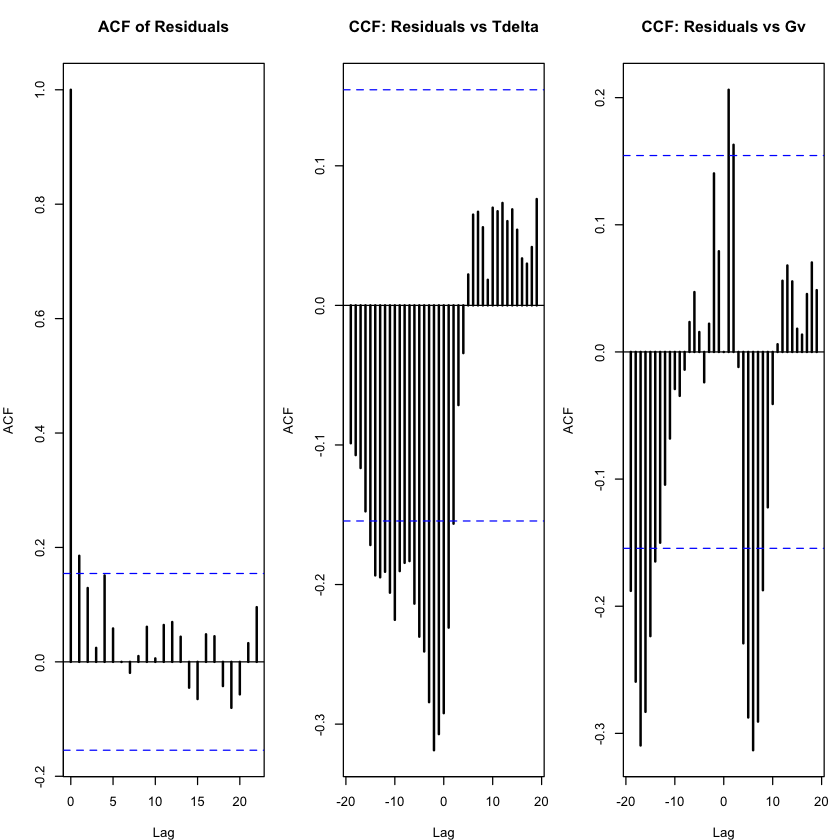

In [216]:
X <- as.data.frame(Dtrain)
residuals <- na.omit(Dtrain$Ph - arx_onestep(5, L[[1]], X))
# Set up 1x3 subplot layout
par(mfrow = c(1, 3), mar = c(4, 4, 4, 1), bg = 'white')

# Plot 1: ACF of residuals
acf(residuals, main = "ACF of Residuals",  lwd = 2)

# Plot 2: CCF with Tdelta
ccf(residuals, Dtrain$Tdelta[6:length(Dtrain$Tdelta)], main = "CCF: Residuals vs Tdelta", lwd = 2)


# Plot 3: CCF with Gv
ccf(residuals, Dtrain$Gv[6:length(Dtrain$Gv)], main = "CCF: Residuals vs Gv", lwd = 2)


# Save the plot as PNG
dev.copy(png, file = "3_6_residuals.png", width = 900, height = 300, res = 100)
dev.off()


quartz_off_screen 
                3

pdf 
  2

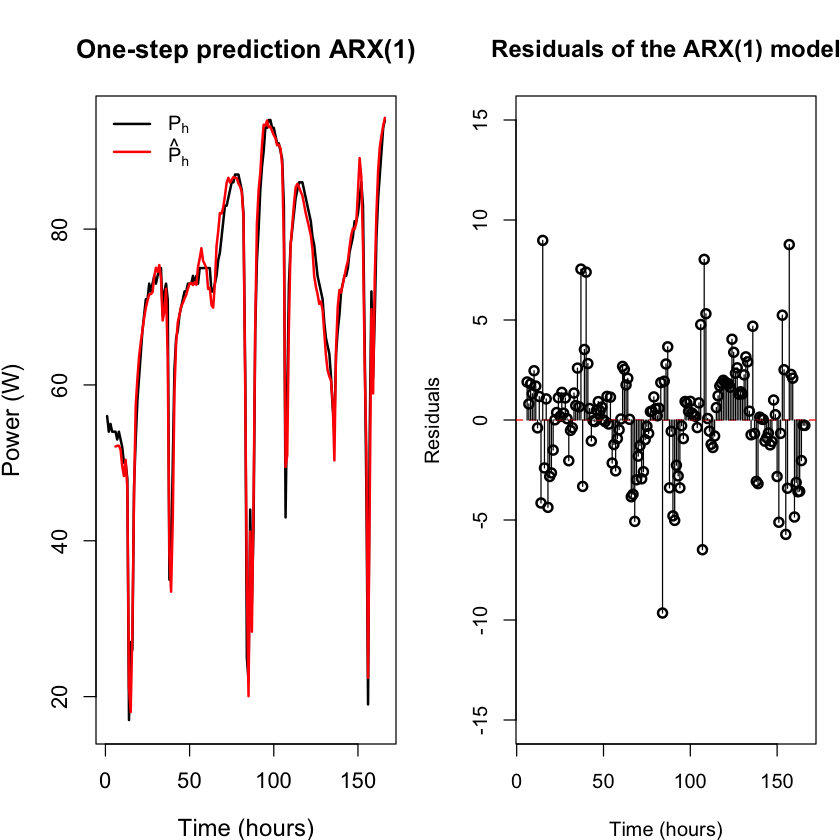

In [219]:
par(mfrow=c(1,2), mar=c(4,4,4,1), bg = 'white') 
plot(Dtrain$Ph, type = "l", lwd = 2, col = "black",
     xlab = "Time (hours)", ylab = "Power (W)",
     main = "One-step prediction ARX(1)",
     cex.lab = 1.2, cex.axis = 1.1, cex.main = 1.3)

lines(arx_onestep(5, L[[1]], X), col = "red", lwd = 2)

legend("topleft", legend = c(expression(P[h]), expression(hat(P)[h])),
       col = c("black", "red"), lty = 1, lwd = 2, bty = "n")
plot(Dtrain$thour[6:length(Dtrain$thour)], residuals, type = "p", col = "black", lwd = 2, xlab = "Time (hours)",
    ylab = "Residuals", main = "Residuals of the ARX(1) model",ylim=c(-15,15))
abline(h = 0, col = "red", lty = 2)
segments(Dtrain$thour[6:length(Dtrain$thour)], 0, Dtrain$thour[6:length(Dtrain$thour)], residuals, col = "black", lty = 1)
dev.copy(png, file = "3_6_predict.png", width = 1200, height = 600, res = 100)
dev.off()

quartz_off_screen 
                3

pdf 
  2

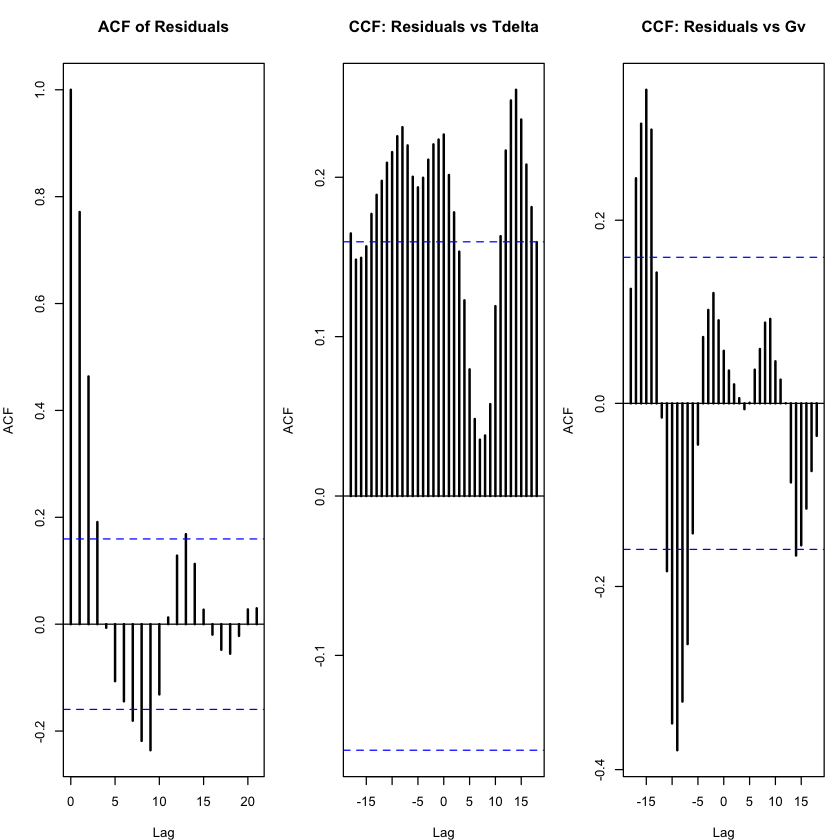

In [192]:
# Set up 1x3 subplot layout
par(mfrow = c(1, 3), mar = c(4, 4, 4, 1), bg = 'white')

# Plot 1: ACF of residuals
acf(residuals, main = "ACF of Residuals",  lwd = 2)

# Plot 2: CCF with Tdelta
ccf(residuals, Dtrain$Tdelta, main = "CCF: Residuals vs Tdelta", lwd = 2)


# Plot 3: CCF with Gv
ccf(residuals, Dtrain$Gv, main = "CCF: Residuals vs Gv", lwd = 2)


# Save the plot as PNG
dev.copy(png, file = "3_6_residuals.png", width = 900, height = 300, res = 100)
dev.off()


In [186]:
L$ARX2 <- lm(Ph ~ 0 + Ph.l1 + Ph.l2 + Tdelta.l0 + Tdelta.l1 + Gv.l0 + Gv.l1, data = Dtrain)

L$ARX3 <- lm(Ph ~ 0 + Ph.l1 + Ph.l2 + Ph.l3 + Tdelta.l0 + Tdelta.l1 + Tdelta.l2 + Gv.l0 + Gv.l1 + Gv.l2, data = Dtrain)

L$ARX4 <- lm(Ph ~ 0 + Ph.l1 + Ph.l2 + Ph.l3 + Ph.l4 + Tdelta.l0 + Tdelta.l1 + Tdelta.l2 + Tdelta.l3 + Gv.l0 + Gv.l1 + Gv.l2 + Gv.l3, data = Dtrain)

L$ARX5 <- lm(Ph ~ 0 + Ph.l1 + Ph.l2 + Ph.l3 + Ph.l4 + Ph.l5 + Tdelta.l0 + Tdelta.l1 + Tdelta.l2 + Tdelta.l3 + Tdelta.l4 + Gv.l0 + Gv.l1 + Gv.l2 + Gv.l3 + Gv.l4, data = Dtrain)

L$ARX6 <- lm(Ph ~ 0 + Ph.l1 + Ph.l2 + Ph.l3 + Ph.l4 + Ph.l5 + Ph.l6 + Tdelta.l0 + Tdelta.l1 + Tdelta.l2 + Tdelta.l3 + Tdelta.l4 + Tdelta.l5 + Gv.l0 + Gv.l1 + Gv.l2 + Gv.l3 + Gv.l4 + Gv.l5, data = Dtrain)

L$ARX7 <- lm(Ph ~ 0 + Ph.l1 + Ph.l2 + Ph.l3 + Ph.l4 + Ph.l5 + Ph.l6 + Ph.l7 + Tdelta.l0 + Tdelta.l1 + Tdelta.l2 + Tdelta.l3 + Tdelta.l4 + Tdelta.l5 + Tdelta.l6 + Gv.l0 + Gv.l1 + Gv.l2 + Gv.l3 + Gv.l4 + Gv.l5 + Gv.l6, data = Dtrain)

L$ARX8 <- lm(Ph ~ 0 + Ph.l1 + Ph.l2 + Ph.l3 + Ph.l4 + Ph.l5 + Ph.l6 + Ph.l7 + Ph.l8 + Tdelta.l0 + Tdelta.l1 + Tdelta.l2 + Tdelta.l3 + Tdelta.l4 + Tdelta.l5 + Tdelta.l6 + Tdelta.l7 + Gv.l0 + Gv.l1 + Gv.l2 + Gv.l3 + Gv.l4 + Gv.l5 + Gv.l6 + Gv.l7, data = Dtrain)

L$ARX9 <- lm(Ph ~ 0 + Ph.l1 + Ph.l2 + Ph.l3 + Ph.l4 + Ph.l5 + Ph.l6 + Ph.l7 + Ph.l8 + Ph.l9 + Tdelta.l0 + Tdelta.l1 + Tdelta.l2 + Tdelta.l3 + Tdelta.l4 + Tdelta.l5 + Tdelta.l6 + Tdelta.l7 + Tdelta.l8 + Gv.l0 + Gv.l1 + Gv.l2 + Gv.l3 + Gv.l4 + Gv.l5 + Gv.l6 + Gv.l7 + Gv.l8, data = Dtrain)

L$ARX10 <- lm(Ph ~ 0 + Ph.l1 + Ph.l2 + Ph.l3 + Ph.l4 + Ph.l5 + Ph.l6 + Ph.l7 + Ph.l8 + Ph.l9 + Ph.l10 + Tdelta.l0 + Tdelta.l1 + Tdelta.l2 + Tdelta.l3 + Tdelta.l4 + Tdelta.l5 + Tdelta.l6 + Tdelta.l7 + Tdelta.l8 + Tdelta.l9 + Gv.l0 + Gv.l1 + Gv.l2 + Gv.l3 + Gv.l4 + Gv.l5 + Gv.l6 + Gv.l7 + Gv.l8 + Gv.l9, data = Dtrain)

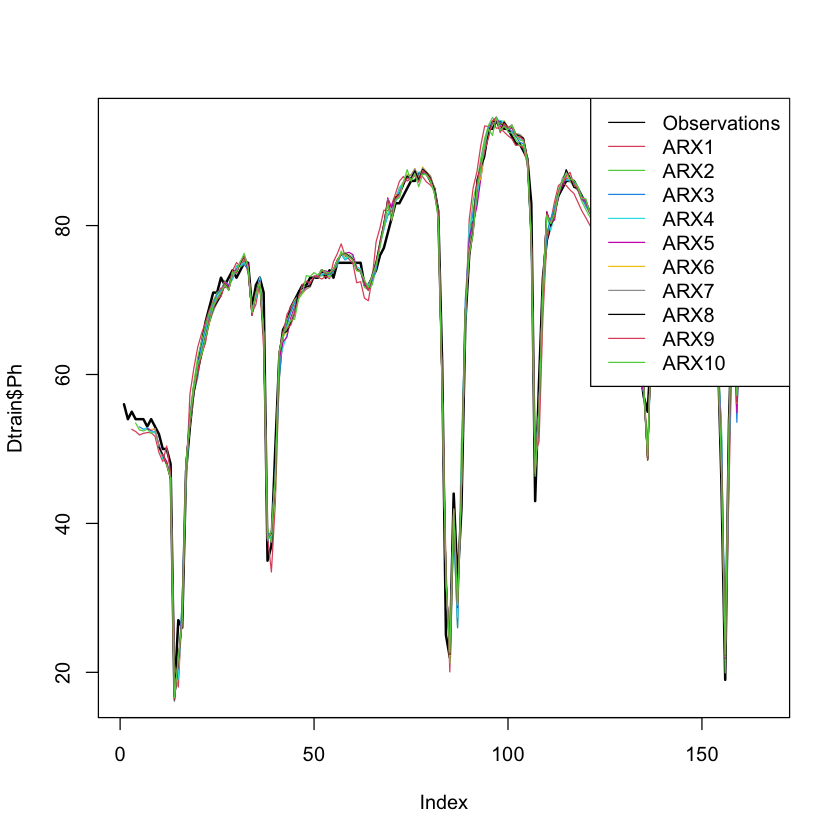

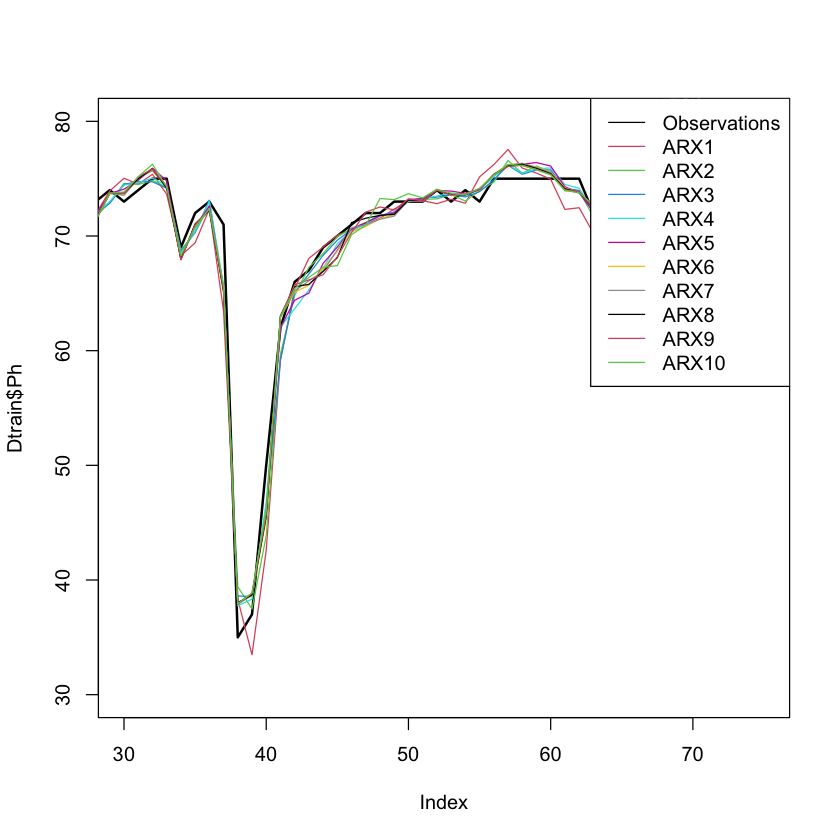

In [187]:
par(bg = "white")
plot(Dtrain$Ph, type="l", lwd=2)  
X <- as.data.frame(Dtrain)
for(i in 1:10){
  lines(arx_onestep(i+1, L[[i]], X), col=i+1)
}
legend("topright", c("Observations",names(L)), lty=1, col=1:(length(L)+1))

par(bg = "white")
plot(Dtrain$Ph, type="l", lwd=2,xlim=c(30,75),ylim = c(30,80))  
X <- as.data.frame(Dtrain)
for(i in 1:10){
  lines(arx_onestep(i+1, L[[i]], X), col=i+1)
}
legend("topright", c("Observations",names(L)), lty=1, col=1:(length(L)+1))

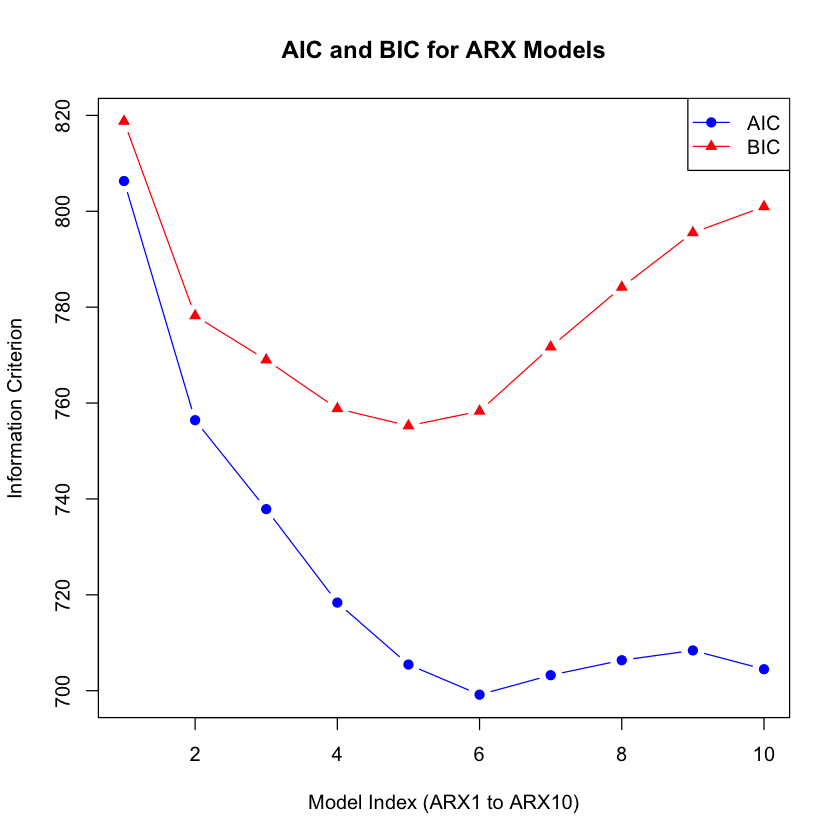

In [188]:
AIC_vec <- sapply(L[1:10], AIC)
BIC_vec <- sapply(L[1:10], BIC)
par(bg = "white")
plot(1:10, AIC_vec, type = "b", pch = 19, col = "blue", ylim = range(c(AIC_vec, BIC_vec)),
     xlab = "Model Index (ARX1 to ARX10)", ylab = "Information Criterion",
     main = "AIC and BIC for ARX Models")
lines(1:10, BIC_vec, type = "b", pch = 17, col = "red")
legend("topright", legend = c("AIC", "BIC"), col = c("blue", "red"), pch = c(19, 17), lty = 1)


## 3.8


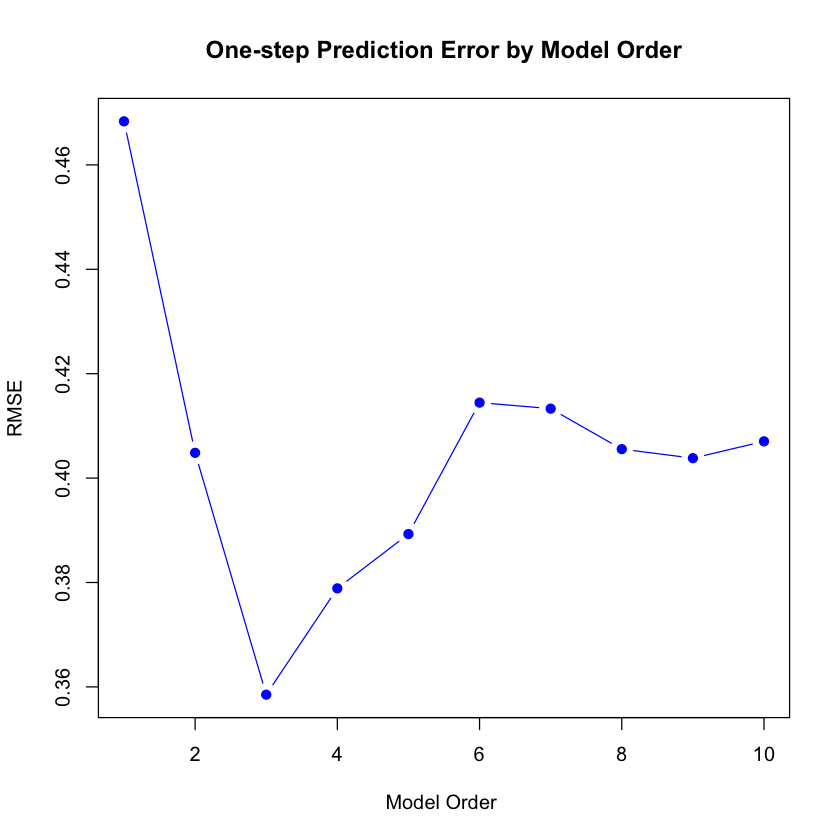

In [189]:
Error <- rep(0,10)
X <- as.data.frame(Dtest)
for(i in 1:10){
  Error[i] <- 1/64*sqrt(sum((Dtest$Ph-arx_onestep(i+1, L[[i]],X))^2,na.rm = TRUE))
}
par(bg="white")
plot(1:10, Error, type = "b", pch = 19, col = "blue",
     xlab = "Model Order ", ylab = "RMSE",
     main = "One-step Prediction Error by Model Order")


## 3.9

In [190]:
bestorder=4
par(bg = "white"$)
plot(D$Ph, type="l", lwd=2)  
X <- as.data.frame(D)
lines(arxmulti(bestorder+1, L[[bestorder]], X), col=2)

ERROR: Error in parse(text = input): <text>:2:18: uventet ')'
1: bestorder=4
2: par(bg = "white"$)
                    ^


In [126]:
paste0("ph",".l",1:5)

[1] "ph.l1" "ph.l2" "ph.l3" "ph.l4" "ph.l5"